Eli Faigle
Recreating Figures 17 and 18 using AWS dataset
Goal of code:
1. Pull data from AWS dataset
2. Bin DENSITY of SST measurements
3. Create figures with SST measurement density's in half-degree spatial bins
4. Create histogram with 10 day binned counts of SST total, SST diurnal, and position and velo measurements

In [1]:
#Used for data manipulation
import numpy as np
import xarray as xr
from scipy import stats
#Others
import time
#Data visualization
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import cmocean



In [2]:
#Time to get the data from AWS; download locally***
file = 'gdp_v2.00.nc'
#url_path = 'https://noaa-oar-hourly-gdp-pds.s3.amazonaws.com/latest/'
#ds = xr.open_dataset(url_path+file+'#mode=bytes')
url_path = '/Users/19082/Desktop/Drifter/'
ds = xr.open_dataset(url_path+file)

c:\Users\19082\miniconda3\lib\site-packages\xarray\backends\plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [3]:
ds

<xarray.Dataset>
Dimensions:                (traj: 17324, obs: 165754333)
Coordinates:
    ID                     (traj) int64 ...
    longitude              (obs) float32 ...
    latitude               (obs) float32 ...
    time                   (obs) datetime64[ns] ...
    ids                    (obs) int64 ...
Dimensions without coordinates: traj, obs
Data variables: (12/53)
    rowsize                (traj) int64 ...
    location_type          (traj) bool ...
    WMO                    (traj) int32 ...
    expno                  (traj) int32 ...
    deploy_date            (traj) datetime64[ns] ...
    deploy_lon             (traj) float32 ...
    ...                     ...
    err_sst                (obs) float32 ...
    err_sst1               (obs) float32 ...
    err_sst2               (obs) float32 ...
    flg_sst                (obs) int8 ...
    flg_sst1               (obs) int8 ...
    flg_sst2               (obs) int8 ...
Attributes: (12/15)
    title:             Global Drifter Program hourly drifting buoy collection
    history:           Version 2.00.  Metadata from dirall.dat and deplog.dat
    Conventions:       CF-1.6
    date_created:      2022-01-14T11:16:01.998226
    publisher_name:    GDP Drifter DAC
    publisher_email:   aoml.dftr@noaa.gov
    ...                ...
    metadata_link:     https://www.aoml.noaa.gov/phod/dac/dirall.html
    contributor_name:  NOAA Global Drifter Program
    contributor_role:  Data Acquisition Center
    institution:       NOAA Atlantic Oceanographic and Meteorological Laboratory
    acknowledgement:   Elipot et al. (2022) to be submitted. Elipot et al. (2...
    summary:           Global Drifter Program hourly data

In [4]:
ds.rowsize

<xarray.DataArray 'rowsize' (traj: 17324)>
[17324 values with dtype=int64]
Coordinates:
    ID       (traj) int64 ...
Dimensions without coordinates: traj
Attributes:
    long_name:  Number of observations per trajectory
    units:      -

In [5]:
traj_idx = np.insert(np.cumsum(ds.rowsize.values), 0, 0)

In [6]:
n = 2578 # What are the other IDs?
j = int(np.where(ds.ID==n)[0])
display('drifter index for ID '+str(n)+' is '+str(j))
ds.sst1[slice(traj_idx[j], traj_idx[j+1])]

'drifter index for ID 2578 is 3974'

<xarray.DataArray 'sst1' (obs: 5137)>
[5137 values with dtype=float32]
Coordinates:
    longitude  (obs) float32 ...
    latitude   (obs) float32 ...
    time       (obs) datetime64[ns] ...
    ids        (obs) int64 ...
Dimensions without coordinates: obs
Attributes:
    long_name:  Fitted non-diurnal sea water temperature
    units:      Kelvin
    comments:   Estimated near-surface non-diurnal sea water temperature from...

Mean Temperature:

In [7]:

lon = np.linspace(-180, 180, 360*2)
lat = np.linspace(-90, 90, 180*2)

ret = stats.binned_statistic_2d(ds.longitude, 
                                ds.latitude,
                                ds.sst,
                                statistic=np.nanmean, 
                                bins=[lon, lat])



c:\Users\19082\miniconda3\lib\site-packages\scipy\stats\_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))


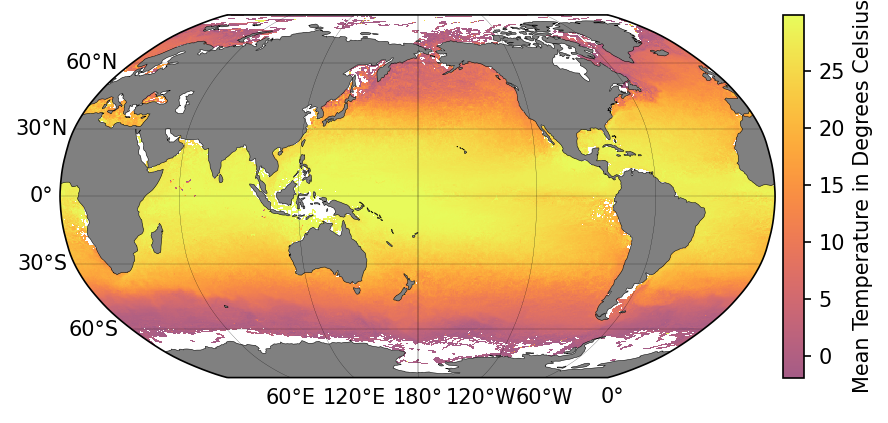

In [66]:
x_c = np.convolve(lon, [0.5, 0.5], mode='valid')
y_c = np.convolve(lat, [0.5, 0.5], mode='valid')

# get 1st and 99th percentiles of values to plot to get a useful range for the colorscale
sst1,sst2 = np.nanpercentile(ret.statistic.T,[1,99])

fig = plt.figure(dpi=150)
ax = fig.add_subplot(1,1,1,projection=ccrs.Robinson(central_longitude=-180))
cmap = cmocean.tools.crop(cmocean.cm.thermal, vmin=sst1-273.15, vmax=sst2-273.15, pivot=0)
pcm = ax.pcolormesh(x_c, y_c, 
                    ret.statistic.T-273.15, 
                    cmap=cmap,
                    transform=ccrs.PlateCarree(),
                    vmin=sst1-273.15, vmax=sst2-273.15)

# gridlines and labels
gl = ax.gridlines(color='k', linewidth=0.1, linestyle='-',
                  xlocs=np.arange(-180, 181, 60), ylocs=np.arange(-90, 91, 30),
                  draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# add land and coastline
ax.add_feature(cfeature.LAND, facecolor='grey', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.25, zorder=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05, axes_class=plt.Axes)
cb = fig.colorbar(pcm, cax=cax);
cb.ax.set_ylabel('Mean Temperature in Degrees Celsius');

Density Measurements:

Maybe use a function?

In [68]:

lon = np.linspace(-180,180, 360*2)
lat = np.linspace(-90, 90, 180*2)

ret1 = stats.binned_statistic_2d(ds.longitude, 
                                ds.latitude,
                                ds.sst,
                                statistic='count', #This maybe for log calues in the legend on figure?
                                bins= [lon, lat])
ret1.statistic.T[ret1.statistic.T == 0] = np.nan


C:\Users\19082\AppData\Local\Temp\ipykernel_20556\996364853.py:12: RuntimeWarning: divide by zero encountered in log10
  np.log10(ret1.statistic.T),
C:\Users\19082\AppData\Local\Temp\ipykernel_20556\996364853.py:15: RuntimeWarning: divide by zero encountered in log10
  vmin=np.log10(sst1a), vmax=np.log10(sst2a))


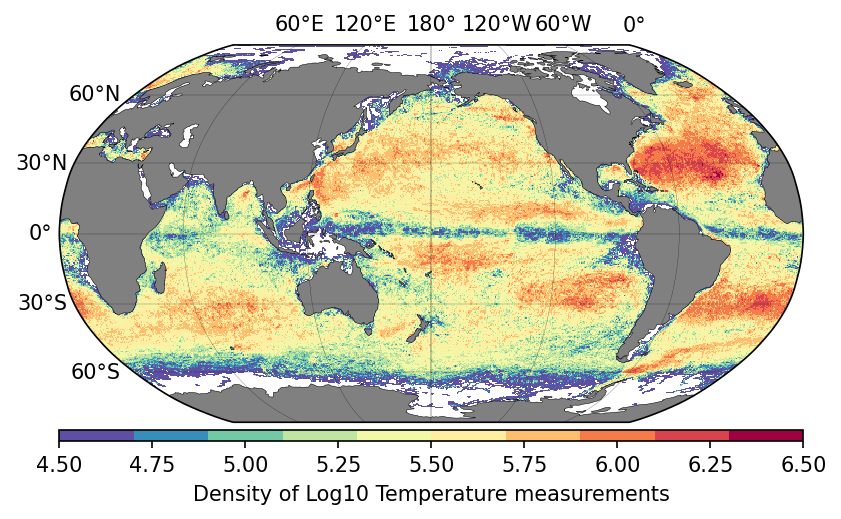

In [67]:
x_c = np.convolve(lon, [0.5, 0.5], mode='valid')
y_c = np.convolve(lat, [0.5, 0.5], mode='valid')


# get 1st and 99th percentiles of values to plot to get a useful range for the colorscale
sst1a, sst2a = np.nanpercentile(ret1.statistic.T,[1,99])  
cmap = plt.cm.get_cmap("Spectral_r", 10)

fig = plt.figure(dpi=150)
ax = fig.add_subplot(1,1,1,projection=ccrs.Robinson(central_longitude=-180))
image = plt.pcolormesh(x_c, y_c,
                       np.log10(ret1.statistic.T), 
                       cmap=cmap, 
                       transform=ccrs.PlateCarree(),
                       vmin=np.log10(sst1a), vmax=np.log10(sst2a)) 
plt.clim(4.5, 6.5)

#pcm = ax.pcolormesh(x_c, y_c, 
                    #ret1.statistic.T,  
                    #cmap=cmap
                    #transform=ccrs.PlateCarree()
                    #vmin=sst1, vmax=sst2)

# gridlines and labels
gl = ax.gridlines(color='k', linewidth=0.1, linestyle='-',
                  xlocs=np.arange(-180, 181, 60), ylocs=np.arange(-90, 91, 30),
                  draw_labels=True)
gl.bottom_labels = False
gl.right_labels = False

# add land and coastline
ax.add_feature(cfeature.LAND, facecolor='grey', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.25, zorder=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="3%", pad=0.05, axes_class=plt.Axes)
cb = fig.colorbar(image, cax=cax, orientation = "horizontal");
cb.ax.set_xlabel('Density of Log10 Temperature measurements');